
# **MiSHAN: IndyGo On-Time Performance Dashboard - Data Analysis & Visualization**
This notebook loads and analyzes IndyGo's on-time performance (OTP) data to generate key insights.
- **Data Source:** IndyGo IU InfoViz Project
- **Libraries Used:** Pandas, Matplotlib, Plotly.
- **Visualizations:** OTP trends, route performance, peak vs. non-peak analysis, etc.


In [ ]:

# Mount Google Drive to access dataset
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import os

# Define dataset pat
data_path= '/content/drive/MyDrive/All'

# Load CSV files
DimBlock = pd.read_csv(f'{data_path}/DimBlock.csv')
DimDate = pd.read_csv(f'{data_path}/DimDate.csv')
DimRoute = pd.read_csv(f'{data_path}/DimRoute.csv')
DimStop = pd.read_csv(f'{data_path}/DimStop.csv')
DimTrip = pd.read_csv(f'{data_path}/DimTrip.csv')
DimUser = pd.read_csv(f'{data_path}/DimUser.csv')
DimUser2 = pd.read_csv(f'{data_path}/DimUser2.csv')
DimVehicle = pd.read_csv(f'{data_path}/DimVehicle.csv')
FactTimepointAdherence = pd.read_csv(f'{data_path}/FactTimepointAdherence.csv')
FactHeadwayAdherence = pd.read_csv(f'{data_path}/FactHeadwayAdherence.csv')

DimUserMerged = pd.concat([DimUser, DimUser2], ignore_index=True)
DimRouteSubset = DimRoute[["RouteKey", 'RouteSortInternetName' , "RouteFareboxID", "MonitoredForHeadway"]]

# Display sample data
FactTimepointAdherence.head()




,TransitAuthorityKey,DateKey,RouteKey,TripKey,UserKey,DepartTimeVarianceSecs,ArriveTimeVarianceSecs
0,1,9352,2038,186704,1024,-15.0,-51.0
1,1,9352,2038,186711,1024,7.0,NaN
2,1,9352,2038,184344,1087,98.0,-84.0
3,1,9352,2038,184352,1087,263.0,191.0
4,1,9352,2038,184360,1087,55.0,-4.0


### Joining TimePoint Table and Route Tables

In [ ]:
# Perform a left join on 'RouteKey'
TimepointRouteSubset = FactTimepointAdherence.merge(DimRouteSubset, on="RouteKey", how="left")


## **1. OTP Monthly Trends (Line Chart)**

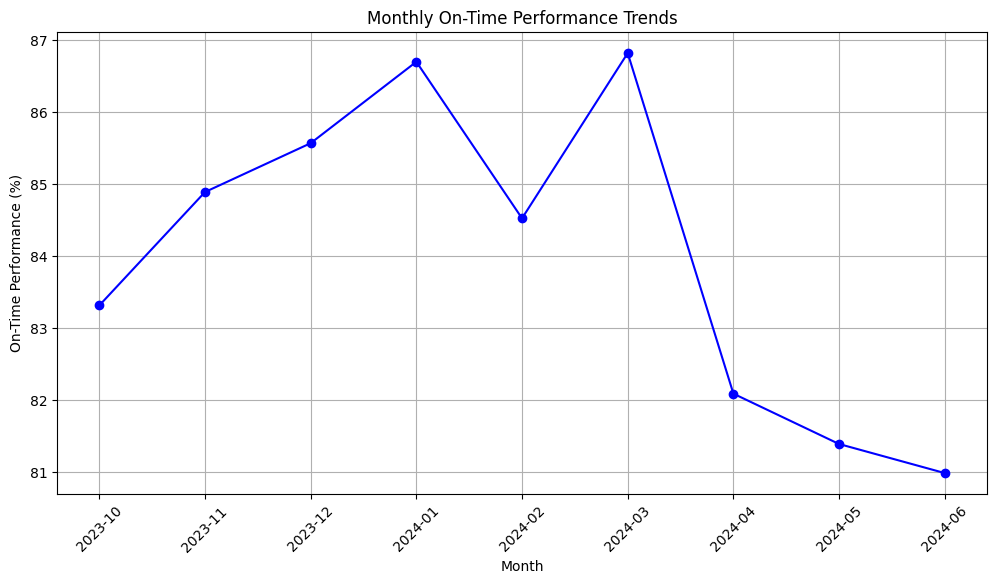

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


if 'DateKey' in FactTimepointAdherence.columns and 'DateKey' in DimDate.columns:

    FactTimepointAdherence = FactTimepointAdherence.merge(DimDate[['DateKey', 'CalendarDate']], on='DateKey', how='left')
else:
    print("Error: 'DateKey' column is missing in either FactTimepointAdherence or DimDate")


FactTimepointAdherence['CalendarDate'] = pd.to_datetime(FactTimepointAdherence['CalendarDate'], errors='coerce')


if FactTimepointAdherence['CalendarDate'].isnull().sum() > 0:
    print("Warning: Some rows have missing CalendarDate values after merging.")


FactTimepointAdherence['OTP_Flag'] = ((FactTimepointAdherence['DepartTimeVarianceSecs'].abs() <= 300) |
                              (FactTimepointAdherence['ArriveTimeVarianceSecs'].abs() <= 300)).astype(int)


FactTimepointAdherence['Month'] = FactTimepointAdherence['CalendarDate'].dt.to_period('M')
monthly_otp = FactTimepointAdherence.groupby('Month')['OTP_Flag'].mean().reset_index()


monthly_otp['Month'] = monthly_otp['Month'].astype(str)

# Plot Monthly OTP Trends
plt.figure(figsize=(12,6))
plt.plot(monthly_otp['Month'], monthly_otp['OTP_Flag'] * 100, marker='o', linestyle='-', color='b')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('On-Time Performance (%)')
plt.title('Monthly On-Time Performance Trends')
plt.grid()
plt.show()


## **2. OTP Performance by Route Category (Bar Chart)**

In [ ]:
import pandas as pd

RouteAbstime = (
    TimepointRouteSubset
    .groupby("RouteKey")["ArriveTimeVarianceSecs"]
    .apply(lambda x: x.clip(lower=0).mean())
    .reset_index(name="MeanNonNegativeArriveVarianceSecs")
)

RouteAbstime = RouteAbstime.merge(
    DimRouteSubset,
    on="RouteKey",
    how="left"
)

# Sort in order
RouteAbstime = RouteAbstime.sort_values("RouteFareboxID")

RouteDelay = (
    RouteAbstime
    .groupby("RouteFareboxID")["MeanNonNegativeArriveVarianceSecs"]
    .sum()
    .reset_index()
)

RouteDelayName = (
    RouteAbstime
    .groupby("RouteSortInternetName")["MeanNonNegativeArriveVarianceSecs"]
    .sum()
    .reset_index()
)

DimRouteSubset = DimRoute[["RouteKey", 'RouteSortInternetName' , "RouteFareboxID", "MonitoredForHeadway"]]

# Perform a left join on 'RouteKey'
TimepointRouteSubset = FactTimepointAdherence.merge(DimRouteSubset, on="RouteKey", how="left")

RouteDelayName = (
    RouteAbstime
    .groupby("RouteSortInternetName")["MeanNonNegativeArriveVarianceSecs"]
    .sum()
    .reset_index()
)

Taking the negative values as 0 because we don't want the instances of early arrivals to pad the poor performance evidence

### Mapping the route names to get a clean visual

In [ ]:
route_name_mapping = {
    '0000000010th Street': '10th Street',
    '0000000030th Street Crosstown': '30th Street Crosstown',
    '0000000086th St Crosstown': '86th St Crosstown',
    'Beech Grove': 'Beech Grove',
    'Broad Ripple': 'Broad Ripple',
    'Castleton': 'Castleton',
    'Deadhead': 'Deadhead',
    'East 0000000016th St': 'East 16th St',
    'East 0000000021st St': 'East 21st St',
    'East 0000000025th St': 'East 25th St',
    'East 0000000034th St': 'East 34th St',
    'East 0000000038th St': 'East 38th St',
    'Eastside Circulator': 'Eastside Circulator',
    'Emerson': 'Emerson',
    'Fort Harrison': 'Fort Harrison',
    'Harding': 'Harding',
    'Keystone': 'Keystone',
    'ML King/Michigan Rd': 'ML King/Michigan Rd',
    'Mars Hill': 'Mars Hill',
    'Michigan Street': 'Michigan Street',
    'Nora': 'Nora',
    'Park 0000000100': 'Park 100',
    'Raymond Street': 'Raymond Street',
    'Red Line': 'Red Line',
    'Red Line - County Line Rd': 'Red Line - County Line Rd',
    'St. Vincent': 'St. Vincent',
    'U S 0000000031': 'U S 31',
    'Washington': 'Washington',
    'West 0000000016th St': 'West 16th St',
    'West 0000000034th St': 'West 34th St',
    'West 0000000038th St': 'West 38th St'
}

RouteDelayName['RouteSortInternetName'] = RouteDelayName['RouteSortInternetName'].map(route_name_mapping)

### Plotting the Graph

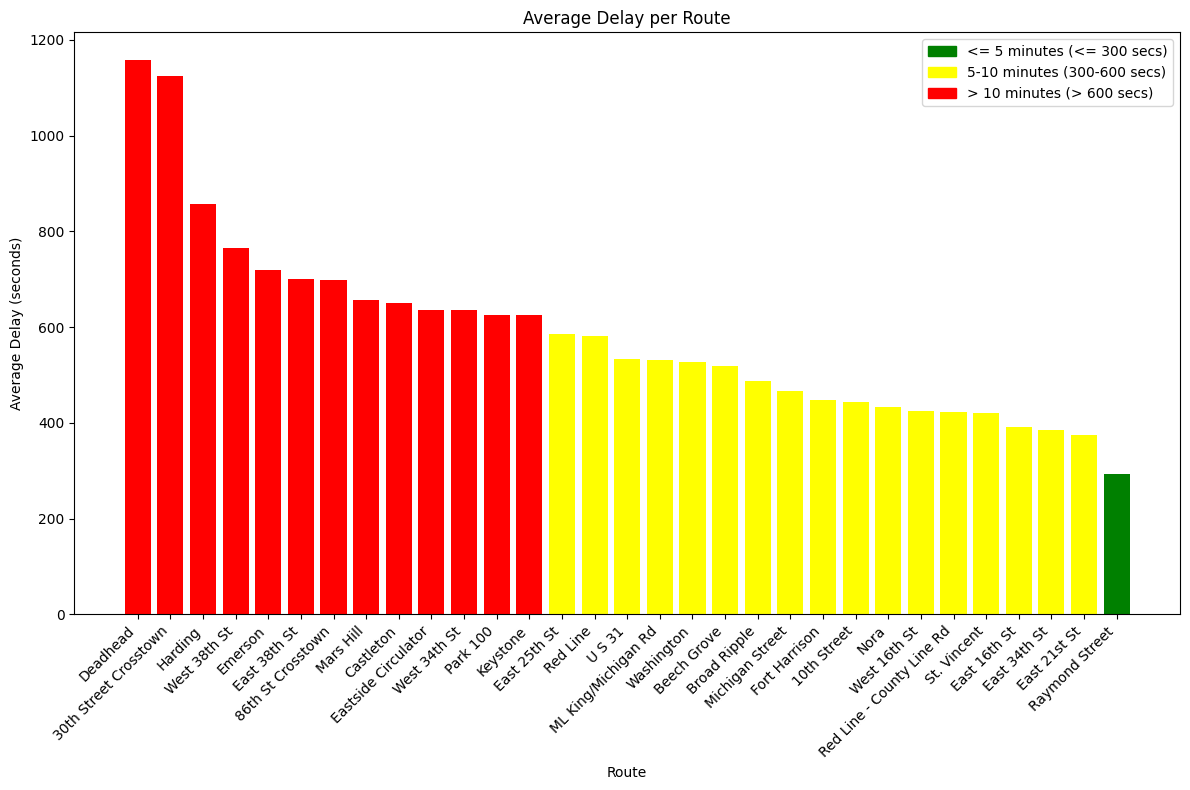

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Sort in descending order by the average delay
RouteDelayName = RouteDelayName.sort_values(
    "MeanNonNegativeArriveVarianceSecs", ascending=False
)


RouteDelayName['RouteSortInternetName'] = RouteDelayName['RouteSortInternetName'].astype(str)


colors = []
for val in RouteDelayName['MeanNonNegativeArriveVarianceSecs']:
    if val <= 300:  # up to 5 minutes
        colors.append('green')
    elif val <= 600:  # 5-10 minutes
        colors.append('yellow')
    else:  # above 10 minutes
        colors.append('red')

plt.figure(figsize=(12, 8))
plt.bar(
    RouteDelayName['RouteSortInternetName'],
    RouteDelayName['MeanNonNegativeArriveVarianceSecs'],
    color=colors,
    width=0.8
)

plt.xlabel("Route")
plt.ylabel("Average Delay (seconds)")
plt.title("Average Delay per Route")


plt.xticks(rotation=45, ha='right')


green_patch = mpatches.Patch(color='green', label='<= 5 minutes (<= 300 secs)')
yellow_patch = mpatches.Patch(color='yellow', label='5-10 minutes (300-600 secs)')
red_patch = mpatches.Patch(color='red', label='> 10 minutes (> 600 secs)')

plt.legend(handles=[green_patch, yellow_patch, red_patch], loc='upper right')

plt.tight_layout()
plt.show()


## **3. OTP trend for specific routes over the past 12 months**

<ipython-input-48-99e6f2581349>:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  route_monthly_otp['RouteReportLabel'].fillna("Route " + route_monthly_otp['RouteKey'].astype(str), inplace=True)


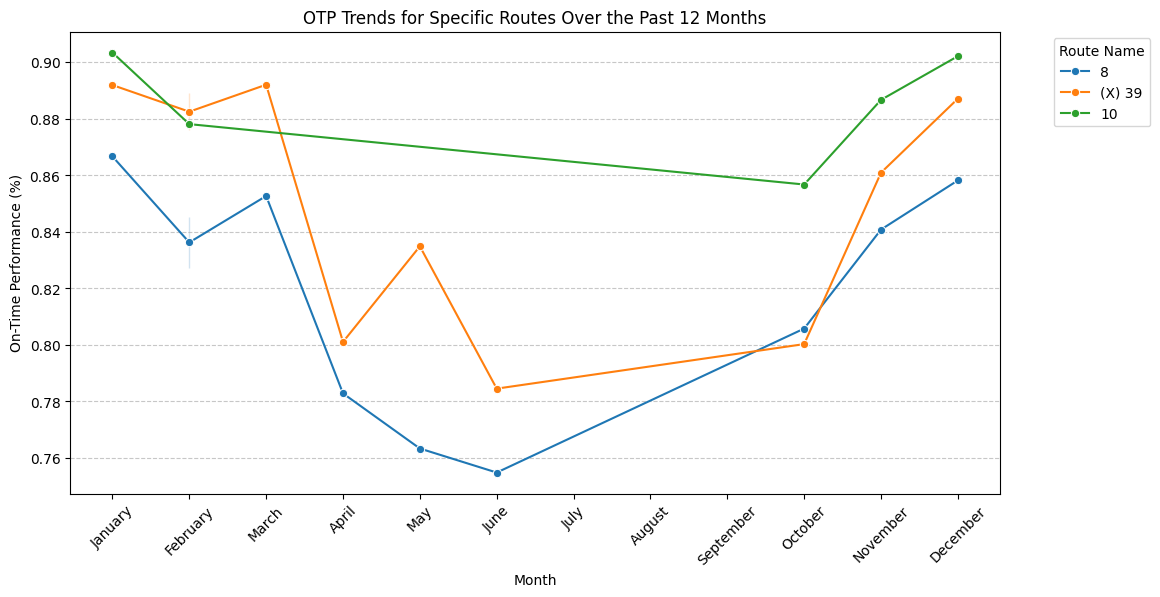

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

FactTimepointAdherence = FactTimepointAdherence.drop(columns=[col for col in FactTimepointAdherence.columns if '_x' in col or '_y' in col], errors='ignore')


if 'MonthName' in DimDate.columns:
    month_col = 'MonthName'
elif 'MonthShortName' in DimDate.columns:
    month_col = 'MonthShortName'
elif 'MonthNumber' in DimDate.columns:
    month_col = 'MonthNumber'
else:
    raise KeyError("No valid month column found in DimDate!")


FactTimepointAdherence = FactTimepointAdherence.merge(DimDate[['DateKey', month_col]], on='DateKey', how='left')


if month_col == 'MonthNumber':
    month_mapping = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
                     7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
    FactTimepointAdherence['MonthName'] = FactTimepointAdherence[month_col].map(month_mapping)
else:
    FactTimepointAdherence.rename(columns={month_col: 'MonthName'}, inplace=True)


if 'MonthName' not in FactTimepointAdherence.columns:
    raise KeyError("MonthName is still missing! Check column names in DimDate.")


FactTimepointAdherence['OTP_Flag'] = ((FactTimepointAdherence['DepartTimeVarianceSecs'].abs() <= 300) |
                              (FactTimepointAdherence['ArriveTimeVarianceSecs'].abs() <= 300)).astype(int)


top_routes = FactTimepointAdherence['RouteKey'].value_counts().head(5).index


filtered_data = FactTimepointAdherence[FactTimepointAdherence['RouteKey'].isin(top_routes)]


route_monthly_otp = filtered_data.groupby(['MonthName', 'RouteKey'])['OTP_Flag'].mean().reset_index()


month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
route_monthly_otp['MonthName'] = pd.Categorical(route_monthly_otp['MonthName'], categories=month_order, ordered=True)


route_monthly_otp = route_monthly_otp.merge(DimRoute[['RouteKey', 'RouteReportLabel']], on='RouteKey', how='left')


route_monthly_otp['RouteReportLabel'].fillna("Route " + route_monthly_otp['RouteKey'].astype(str), inplace=True)


plt.figure(figsize=(12,6))
sns.lineplot(x='MonthName', y='OTP_Flag', hue='RouteReportLabel', data=route_monthly_otp, marker='o')

plt.xlabel("Month")
plt.ylabel("On-Time Performance (%)")
plt.title("OTP Trends for Specific Routes Over the Past 12 Months")
plt.xticks(rotation=45)
plt.legend(title="Route Name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## **4. Stop-Level OTP Heatmap**

In [ ]:
import folium
from folium.plugins import HeatMap
import pandas as pd

FactTimepointAdherence['OTP_Flag'] = ((FactTimepointAdherence['DepartTimeVarianceSecs'].abs() <= 300) |
                              (FactTimepointAdherence['ArriveTimeVarianceSecs'].abs() <= 300)).astype(int)


route_otp = FactTimepointAdherence.groupby('RouteKey')['OTP_Flag'].mean().reset_index()


DimStop['Estimated_OTP'] = route_otp['OTP_Flag'].mean()  # Approximate OTP


stop_otp = DimStop.dropna(subset=['Latitude', 'Longitude', 'Estimated_OTP'])


m = folium.Map(location=[39.7684, -86.1581], zoom_start=11)  # Centered at Indianapolis


HeatMap(stop_otp[['Latitude', 'Longitude', 'Estimated_OTP']], radius=8, blur=6).add_to(m)


m
